Many of the RDKit's fingerprints are available as either bit vectors or count vectors. Bit vectors track whether or not features appear in a molecule while count vectors track the number of times each feature appears. It seems intuitive that a count vector is a better representation of similarity than bit vectors, but we often use bit vector representations for computational expediency - bit vectors require less memory and are much faster to operate on.

What impact does this using bit vectors have on computed similarity values and the ordering of similarities? This notebook attempts to provide at least a partial answer to that question and also examines a strategy for simulating counts using bit vectors.
I look at the following fingerprints:
- Morgan 2
- Topological Torsion
- Atom Pair
- RDKit

And I use two sets of compunds:
- Random pairs of compounds taken from [this blog post](https://greglandrum.github.io/rdkit-blog/fingerprints/similarity/reference/2021/05/18/fingerprint-thresholds1.html)
- Pairs of "related compounds" taken from [this blog post](https://greglandrum.github.io/rdkit-blog/similarity/reference/2021/05/21/similarity-search-thresholds.html)

## Bit vector similarity vs count-based similarity

Let's start with two molecules where this makes a big difference:
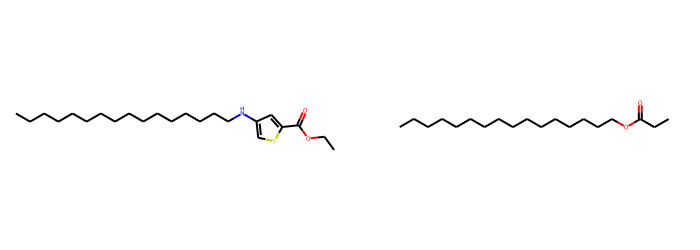
The calculated similarity with MFP2 and counts is 0.6 while with bits it's 0.29. That's easy to understand since with the bit-based fingerprints the long alkyl chains don't make the large ontribution to the similarity that they do when using counts.

To demonstrate that this isn't all about long chains, here's another pair where there's a significant difference:
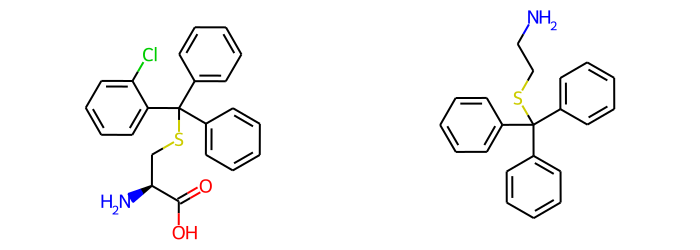
In this case the count-based similarity is 0.59 while with bits it's 0.35. 

Those were a couple of anecdotes, but let's look at the differences across the entire datasets:
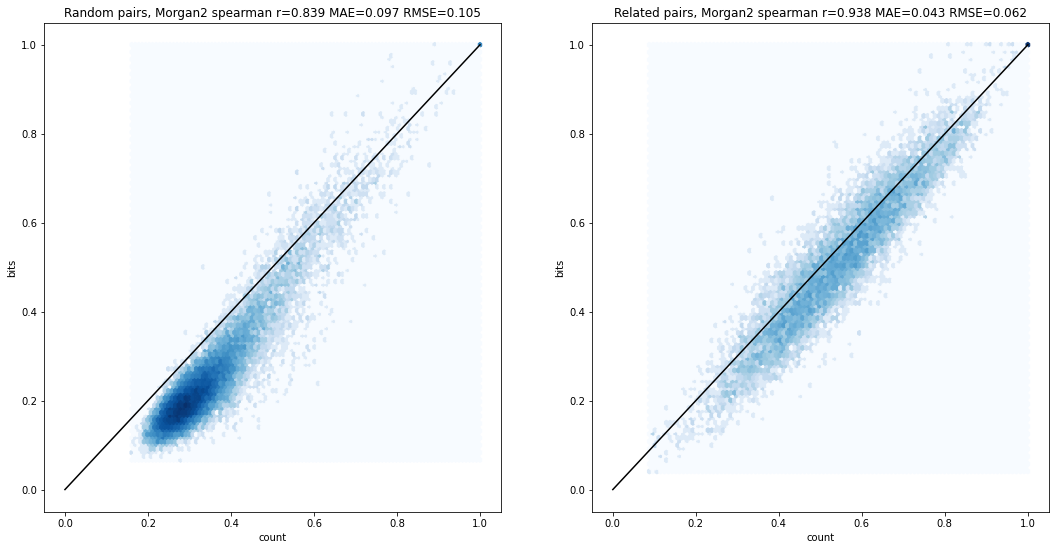
Here I've plotted bit-based similarity vs count-based similarity and included statistics on the correlation in the title. The left plot is for the random compound pairs and the right plot is for the related compound pairs.
There are significant differences in similarity here, with the bit vector similarities being consistently lower than the count-based equivalent, but it's worth pointing out that the rankings of the similarities (as measured by the Spearman rank-order correlation values) are reasonably equivalent, particularly for the related compound pairs.

The equivalent plots for the RDKit fingerprint show the same qualitative behavior with the difference that bit vector similarities tend to be *higher* than count based similarities:
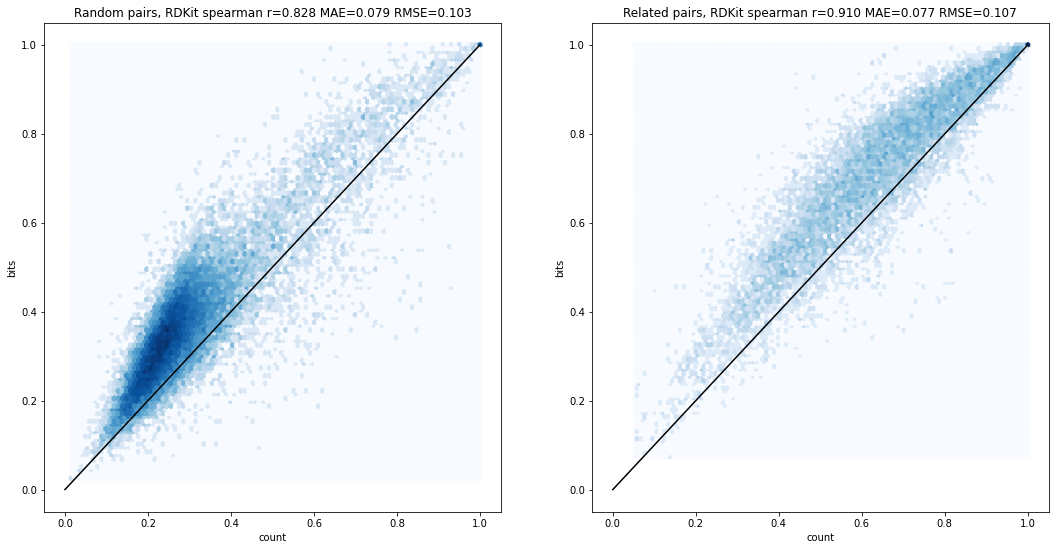

## Simulating counts

The RDKit has a simple mechanism for simulating counts using bit vectors: set multiple bits for each feature where the number of bits set is determined by the count. The approach uses a fixed number of potential bits which each have a threshold value; if the count for the feature exceeds the threshold value then the corresponding bit is set. Here's a schematic illustration for count simulation with four bits and the thresholds 1, 2, 4, and 8:
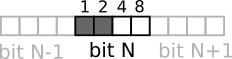
The example shown, with the first two bits set for feature N, is what we'd get if feature N is set either 2 or 3 times in a molecule.
Note that we aren't just using a binary representation of the count itself. In that case a feature which is present one time in the first molecule, representation `1000`, and two times in the second molecule, representation `0100`, would contribute zero to the overall similarity. That's not desirable.

Note that since the count simulation approach uses multiple bits per feature, it decreases the effective length of the fingerprint by a factor equal to the number of bits used. With the default setting of four bits per feature a 2048 bit fingerprint will have the same number of bit collisions as a 512 bit fingerprint without count simulation. This becomes more relevant the more bits a fingerprint tends to set. For example using count simulation to calculate similarity with the RDKit fingerprint, which [sets a large number of bits](https://greglandrum.github.io/rdkit-blog/fingerprints/reference/2021/07/06/number-of-fp-bits-set.html), actually decreases the correlation with the similarity calculated with count vectors (see below for the plot) unless I also increase the overall length of the fingerprint.


## Results and discussion

Here's a summary of the results for the fingerprints I examine here


<table>
    <tr> <th>Random pairs</th> <th colspan=3 style="text-align:center">Bits--Count</th> <th colspan=3 style="text-align:center">Count simulation--Count</th>
    </tr> 
    <tr> <th>Fingerprint</th> <th>Spearman r</th> <th>MAE</th> <th>RMSE</th>
        <th>Spearman r</th> <th>MAE</th> <th>RMSE</th> <th>Note</th>
    </tr>
    <tr> <td>Morgan 2</td>
        <td>0.84</td><td>0.097</td><td>0.10</td>
        <td>0.90</td><td>0.024</td><td>0.036</td>
        <td></td>
    </tr>
    <tr> <td>Topological torsions</td>
        <td>0.92</td><td>0.026</td><td>0.051</td>
        <td>0.98</td><td>0.018</td><td>0.029</td>
        <td></td>
    </tr>
    <tr> <td>Topological torsions</td>
        <td>0.92</td><td>0.026</td><td>0.051</td>
        <td>0.99</td><td>0.010</td><td>0.021</td>
        <td>8192 bits for count simulation</td>
    </tr>
    <tr> <td>Atom pairs</td>
        <td>0.82</td><td>0.031</td><td>0.049</td>
        <td>0.90</td><td>0.055</td><td>0.066</td>
        <td></td>
    </tr>
    <tr> <td>Atom pairs</td>
        <td>0.82</td><td>0.031</td><td>0.049</td>
        <td>0.96</td><td>0.014</td><td>0.023</td>
        <td>8192 bits for count simulation</td>
    </tr>
    <tr> <td>RDKit</td>
        <td>0.83</td><td>0.079</td><td>0.10</td>
        <td>0.94</td><td>0.029</td><td>0.045</td>
        <td>8192 bits for count simulation</td>
    </tr>
</table>    

<table>
    <tr> <th>Related pairs</th> <th colspan=3 style="text-align:center">Bits--Count</th> <th colspan=3 style="text-align:center">Count simulation--Count</th>
    </tr> 
    <tr> <th>Fingerprint</th> <th>Spearman r</th> <th>MAE</th> <th>RMSE</th>
        <th>Spearman r</th> <th>MAE</th> <th>RMSE</th> <th>Note</th>
    </tr>
    <tr> <td>Morgan 2</td>
        <td>0.94</td><td>0.043</td><td>0.062</td>
        <td>0.98</td><td>0.019</td><td>0.028</td>
        <td></td>
    </tr>
    <tr> <td>Topological torsions</td>
        <td>0.90</td><td>0.050</td><td>0.079</td>
        <td>0.98</td><td>0.021</td><td>0.035</td>
        <td></td>
    </tr>
    <tr> <td>Topological torsions</td>
        <td>0.90</td><td>0.050</td><td>0.079</td>
        <td>0.98</td><td>0.018</td><td>0.032</td>
        <td>8192 bits for count simulation</td>
    </tr>
    <tr> <td>Atom pairs</td>
        <td>0.91</td><td>0.043</td><td>0.067</td>
        <td>0.97</td><td>0.052</td><td>0.063</td>
        <td></td>
    </tr>
    <tr> <td>Atom pairs</td>
        <td>0.91</td><td>0.043</td><td>0.067</td>
        <td>0.98</td><td>0.020</td><td>0.032</td>
        <td>8192 bits for count simulation</td>
    </tr>
    <tr> <td>RDKit</td>
        <td>0.91</td><td>0.077</td><td>0.11</td>
        <td>0.98</td><td>0.034</td><td>0.053</td>
        <td>8192 bits for count simulation</td>
    </tr>
</table>    


Using the count simulation strategies does improve the match between similarities calculated with bit vectors and those calculated with count vectors. The differences are statistically significant (results not shown here) and large enough to potentially be meaningful. MAE and RMSE values for the various fingerprints typically decrease by at least a factor of two and Spearman rank-order correlation in general increases quite a bit. These conclusions hold for both randomly paired molecules and related pairs with more dramatic differences seen at the lower ends of the similarity scale (the random pairs).


Note that this analysis focuses solely on similarity. The extra information added by doing count simulation will most likely also influence the performance of machine learning models built using these fingerprints. But that's for a future blog post.


The code to reproduce all of this, along with more plots, is below.

In [1]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import rdMolDescriptors
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics import median_absolute_error, mean_squared_error
import rdkit
print(rdkit.__version__)
%pylab inline

2021.09.1pre
Populating the interactive namespace from numpy and matplotlib


## Some technical notes:

- Note that this notebook uses a couple of features which did not work properly until the v2021.03.4 of the RDKit (which will be released in July).
- Count simulation is only generally available when working with the "new" fingerprint generators, so those are used throughout this notebook.
- Count simulation is used by default for atom pair and topological torsion fingerprints, both with the "new" fingerprint generators and the older fingerprinting functions.

## Construct the dataset.

Start with our standard similarity comparison set:

In [2]:
import gzip
with gzip.open('../data/chembl21_25K.pairs.txt.gz','rt') as inf:
    ls = [x.split() for x in inf.readlines()]
ms = [(Chem.MolFromSmiles(x[1]),Chem.MolFromSmiles(x[3])) for x in ls]

That's weighted towards lower similarity values, get some pairs from the related compounds set:

In [3]:
import pickle
from collections import namedtuple
MCSRes=namedtuple('MCSRes',('smarts','numAtoms','numMols','avgNumMolAtoms','mcsTime'))

data = pickle.load(open('../data/scaffolds_revisited_again.simplified.pkl','rb'))
data2 = pickle.load(open('../data/scaffolds_expanded.simplified.pkl','rb'))
data += data2

# keep only sets where the MCS was at least 50% of the average number of atoms:
keep = [x for x in data if x[2].numAtoms>=np.mean(x[2].avgNumMolAtoms)/2]
len(keep)

import random
random.seed(0xf00d)
related_pairs = []
# keep only molecules matching the MCS:
for i,tpl in enumerate(keep):
    assay,smis,mcs,svg = tpl
    patt = Chem.MolFromSmarts(mcs.smarts)
    smis = [(x,y) for x,y in smis if Chem.MolFromSmiles(y).HasSubstructMatch(patt)]
    ssmis = smis[:]
    random.shuffle(ssmis)
    related_pairs.extend([(x[0],x[1],y[0],y[1]) for x,y in zip(smis,ssmis)][:10])
print(f'{len(related_pairs)} related pairs')
related_ms = [(Chem.MolFromSmiles(x[1]),Chem.MolFromSmiles(x[3])) for x in related_pairs]


10470 related pairs


In [4]:
len(ms)

25000

In [5]:
import random
random.seed(0xf00d)
indices = list(range(len(ms)))
random.shuffle(indices)
random_pairs = [ms[x] for x in indices[:5000]]
indices = list(range(len(related_ms)))
random.shuffle(indices)
related_pairs = [related_ms[x] for x in indices[:5000]]



## Performance of similarity comparisons

In [6]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048,countSimulation=False)
bv_pairs = [(fpgen.GetFingerprint(x[0]),fpgen.GetFingerprint(x[1])) for x in random_pairs]
cv_pairs = [(fpgen.GetCountFingerprint(x[0]),fpgen.GetCountFingerprint(x[1])) for x in random_pairs]

In [7]:
%timeit _ = [DataStructs.TanimotoSimilarity(x,y) for x,y in bv_pairs]

5.06 ms ± 75 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
%timeit _ = [DataStructs.TanimotoSimilarity(x,y) for x,y in cv_pairs]

8.37 ms ± 160 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Not a huge difference there, but what about a fingerprint which sets a much larger number of bits?

In [9]:
fpgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=2048,countSimulation=False)
bv_pairs = [(fpgen.GetFingerprint(x[0]),fpgen.GetFingerprint(x[1])) for x in random_pairs]
cv_pairs = [(fpgen.GetCountFingerprint(x[0]),fpgen.GetCountFingerprint(x[1])) for x in random_pairs]

In [10]:
%timeit _ = [DataStructs.TanimotoSimilarity(x,y) for x,y in bv_pairs]

6.22 ms ± 404 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%timeit _ = [DataStructs.TanimotoSimilarity(x,y) for x,y in cv_pairs]

189 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Here the performance difference is quite noticeable.

## Morgan 2

In [12]:
fpgen1 = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048,countSimulation=False)
fpsims = [DataStructs.TanimotoSimilarity(fpgen1.GetFingerprint(x[0]),fpgen1.GetFingerprint(x[1])) for x in ms]
countsims = [DataStructs.TanimotoSimilarity(fpgen1.GetCountFingerprint(x[0]),fpgen1.GetCountFingerprint(x[1])) for x in ms]
related_fpsims = [DataStructs.TanimotoSimilarity(fpgen1.GetFingerprint(x[0]),fpgen1.GetFingerprint(x[1])) for x in related_ms]
related_countsims = [DataStructs.TanimotoSimilarity(fpgen1.GetCountFingerprint(x[0]),fpgen1.GetCountFingerprint(x[1])) for x in related_ms]


In [13]:
fpgen2 = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048,countSimulation=True)
fpsims_countsim = [DataStructs.TanimotoSimilarity(fpgen2.GetFingerprint(x[0]),fpgen2.GetFingerprint(x[1])) for x in ms]
related_fpsims_countsim = [DataStructs.TanimotoSimilarity(fpgen2.GetFingerprint(x[0]),fpgen2.GetFingerprint(x[1])) for x in related_ms]


In [14]:
delts = sorted([(countsims[i]-fpsims[i],i) for i in range(len(fpsims))])
print(delts[:5])
print(delts[-5:])

[(-0.20329670329670324, 12408), (-0.19358178053830222, 14793), (-0.19191919191919193, 126), (-0.17673378076062635, 1391), (-0.17493796526054584, 13034)]
[(0.31300539083557954, 20013), (0.3151412702245835, 12445), (0.3157622739018088, 13430), (0.3207792207792208, 4381), (0.37206896551724133, 11692)]


Count: 0.60, Bits: 0.29, Simulated counts: 0.42


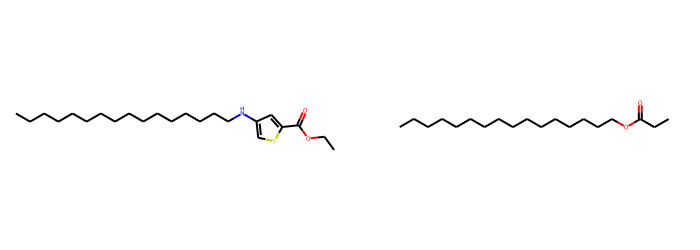

In [15]:
idx = 13430
print(f'Count: {countsims[idx]:.2f}, Bits: {fpsims[idx]:.2f}, Simulated counts: {fpsims_countsim[idx]:.2f}')
Draw.MolsToGridImage(ms[idx],subImgSize=(350,250),molsPerRow=2)

In [16]:
delts = sorted([(related_countsims[i]-related_fpsims[i],i) for i in range(len(related_fpsims))])
print(delts[:5])
print(delts[-5:])

[(-0.26508684133058585, 4359), (-0.24506749740394607, 1322), (-0.2321428571428572, 7602), (-0.21353383458646613, 10080), (-0.20879676440849337, 3804)]
[(0.24318181818181822, 1962), (0.24456938410426782, 1961), (0.24456938410426782, 1969), (0.2455492835432045, 1963), (0.273972602739726, 7774)]


Count: 0.59, Bits: 0.35, Simulated counts: 0.52


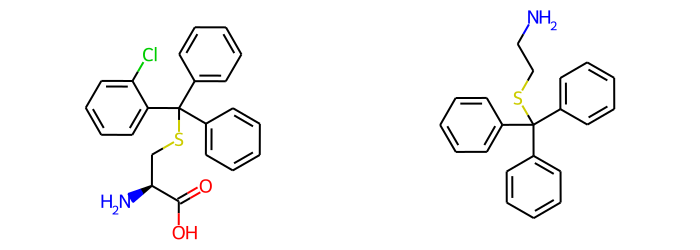

In [17]:
idx = 1969
print(f'Count: {related_countsims[idx]:.2f}, Bits: {related_fpsims[idx]:.2f}, Simulated counts: {related_fpsims_countsim[idx]:.2f}')
Draw.MolsToGridImage(related_ms[idx],subImgSize=(350,250),molsPerRow=2)

Count: 0.39, Bits: 0.65, Simulated counts: 0.51


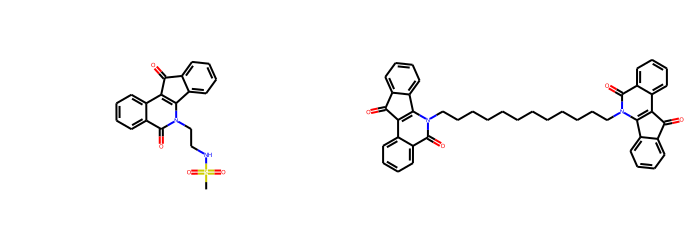

In [18]:
idx = 4359
print(f'Count: {related_countsims[idx]:.2f}, Bits: {related_fpsims[idx]:.2f}, Simulated counts: {related_fpsims_countsim[idx]:.2f}')
Draw.MolsToGridImage(related_ms[idx],subImgSize=(350,250),molsPerRow=2)

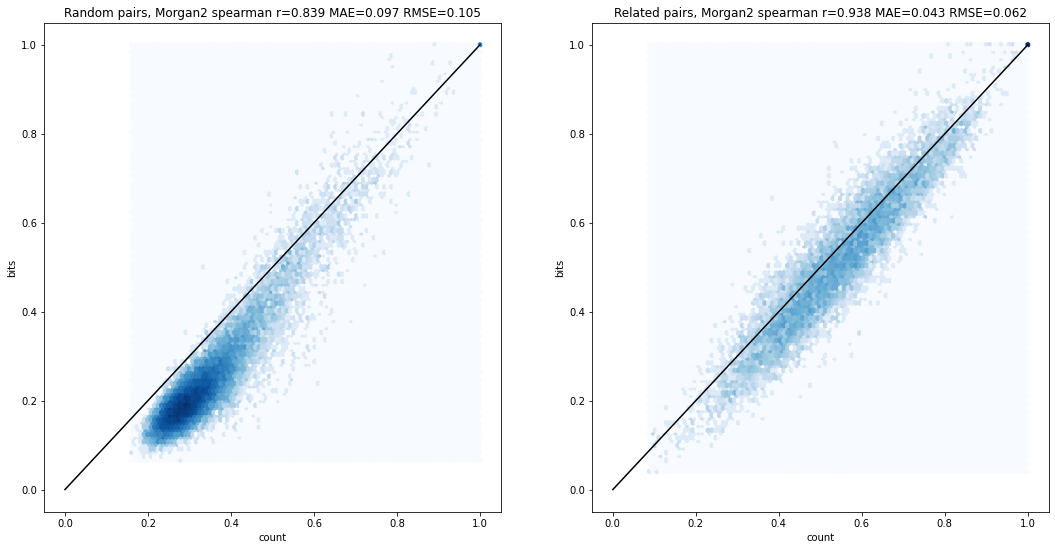

In [19]:
figsize(18,9)
subplot(1,2,1)
y,x = fpsims,countsims
hexbin(x,y,cmap='Blues',bins='log');
plot((0,1),(0,1),'k');
xlabel('count')
ylabel('bits');
sr,p = spearmanr(x,y)
mae = median_absolute_error(x,y)
rmse = sqrt(mean_squared_error(x,y))
title(f'Random pairs, Morgan2 spearman r={sr:.3f} MAE={mae:.3f} RMSE={rmse:.3f}');

subplot(1,2,2)
y,x = related_fpsims,related_countsims
hexbin(x,y,cmap='Blues',bins='log');
plot((0,1),(0,1),'k');
xlabel('count')
ylabel('bits');
sr,p = spearmanr(x,y)
mae = median_absolute_error(x,y)
rmse = sqrt(mean_squared_error(x,y))
title(f'Related pairs, Morgan2 spearman r={sr:.3f} MAE={mae:.3f} RMSE={rmse:.3f}');


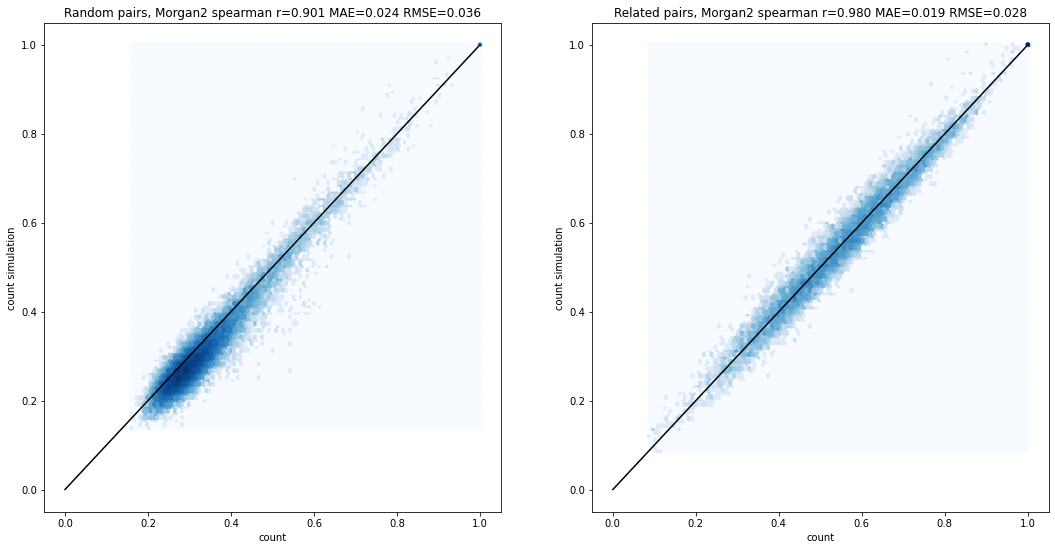

In [20]:
figsize(18,9)
subplot(1,2,1)
x,y = countsims,fpsims_countsim
hexbin(x,y,cmap='Blues',bins='log');
plot((0,1),(0,1),'k');
ylabel('count simulation')
xlabel('count');
sr,p = spearmanr(x,y)
mae = median_absolute_error(x,y)
rmse = sqrt(mean_squared_error(x,y))
title(f'Random pairs, Morgan2 spearman r={sr:.3f} MAE={mae:.3f} RMSE={rmse:.3f}');

subplot(1,2,2)
x,y = related_countsims,related_fpsims_countsim
hexbin(x,y,cmap='Blues',bins='log');
plot((0,1),(0,1),'k');
ylabel('count simulation')
xlabel('count');
sr,p = spearmanr(x,y)
mae = median_absolute_error(x,y)
rmse = sqrt(mean_squared_error(x,y))
title(f'Related pairs, Morgan2 spearman r={sr:.3f} MAE={mae:.3f} RMSE={rmse:.3f}');



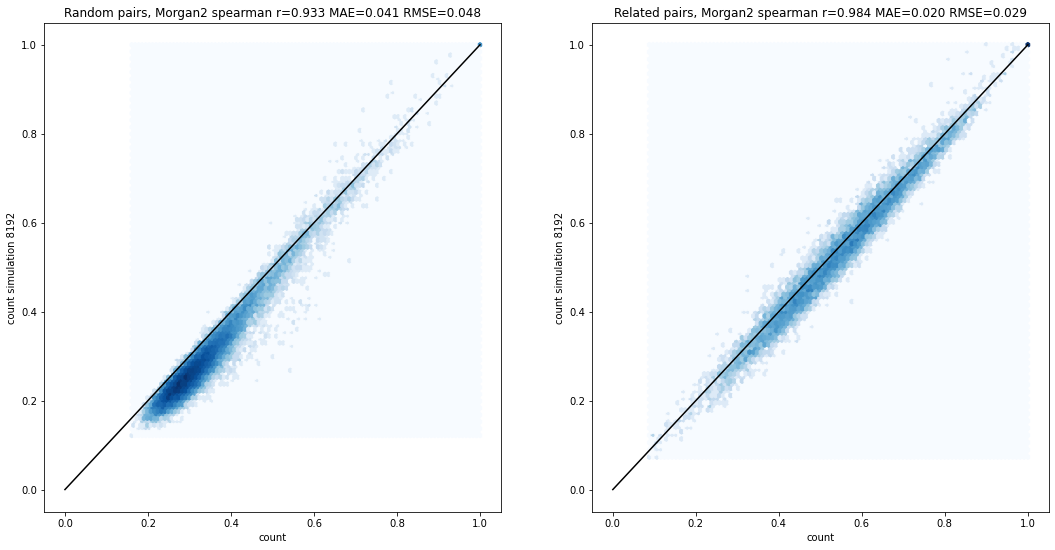

In [21]:
fpgen3 = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=8192,countSimulation=True)
fpsims_countsim2 = [DataStructs.TanimotoSimilarity(fpgen3.GetFingerprint(x[0]),fpgen3.GetFingerprint(x[1])) for x in ms]
related_fpsims_countsim2 = [DataStructs.TanimotoSimilarity(fpgen3.GetFingerprint(x[0]),fpgen3.GetFingerprint(x[1])) for x in related_ms]


figsize(18,9)
subplot(1,2,1)
x,y = countsims,fpsims_countsim2
hexbin(x,y,cmap='Blues',bins='log');
plot((0,1),(0,1),'k');
ylabel('count simulation 8192')
xlabel('count');
sr,p = spearmanr(x,y)
mae = median_absolute_error(x,y)
rmse = sqrt(mean_squared_error(x,y))
title(f'Random pairs, Morgan2 spearman r={sr:.3f} MAE={mae:.3f} RMSE={rmse:.3f}');

subplot(1,2,2)
x,y = related_countsims,related_fpsims_countsim2
hexbin(x,y,cmap='Blues',bins='log');
plot((0,1),(0,1),'k');
ylabel('count simulation 8192')
xlabel('count');
sr,p = spearmanr(x,y)
mae = median_absolute_error(x,y)
rmse = sqrt(mean_squared_error(x,y))
title(f'Related pairs, Morgan2 spearman r={sr:.3f} MAE={mae:.3f} RMSE={rmse:.3f}');




## Topological Torsions

In [22]:
fpgen1 = rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=2048,countSimulation=False)
fpsims = [DataStructs.TanimotoSimilarity(fpgen1.GetFingerprint(x[0]),fpgen1.GetFingerprint(x[1])) for x in ms]
countsims = [DataStructs.TanimotoSimilarity(fpgen1.GetCountFingerprint(x[0]),fpgen1.GetCountFingerprint(x[1])) for x in ms]
related_fpsims = [DataStructs.TanimotoSimilarity(fpgen1.GetFingerprint(x[0]),fpgen1.GetFingerprint(x[1])) for x in related_ms]
related_countsims = [DataStructs.TanimotoSimilarity(fpgen1.GetCountFingerprint(x[0]),fpgen1.GetCountFingerprint(x[1])) for x in related_ms]
fpgen2 = rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=2048,countSimulation=True)
fpsims_countsim = [DataStructs.TanimotoSimilarity(fpgen2.GetFingerprint(x[0]),fpgen2.GetFingerprint(x[1])) for x in ms]
related_fpsims_countsim = [DataStructs.TanimotoSimilarity(fpgen2.GetFingerprint(x[0]),fpgen2.GetFingerprint(x[1])) for x in related_ms]


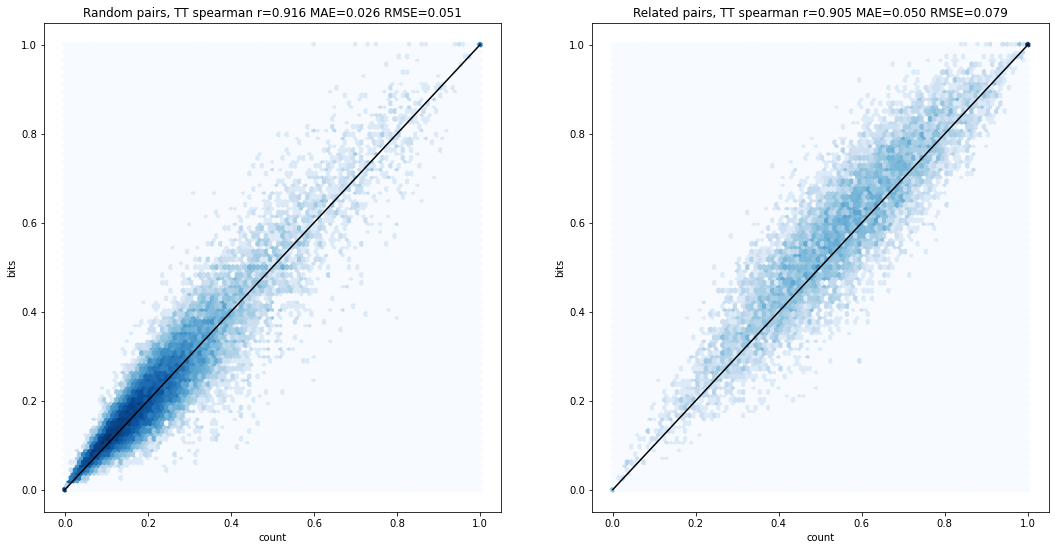

In [23]:
figsize(18,9)
subplot(1,2,1)
y,x = fpsims,countsims
hexbin(x,y,cmap='Blues',bins='log');
plot((0,1),(0,1),'k');
xlabel('count')
ylabel('bits');
sr,p = spearmanr(x,y)
mae = median_absolute_error(x,y)
rmse = sqrt(mean_squared_error(x,y))
title(f'Random pairs, TT spearman r={sr:.3f} MAE={mae:.3f} RMSE={rmse:.3f}');
subplot(1,2,2)
y,x = related_fpsims,related_countsims
hexbin(x,y,cmap='Blues',bins='log');
plot((0,1),(0,1),'k');
xlabel('count')
ylabel('bits');
sr,p = spearmanr(x,y)
mae = median_absolute_error(x,y)
rmse = sqrt(mean_squared_error(x,y))
title(f'Related pairs, TT spearman r={sr:.3f} MAE={mae:.3f} RMSE={rmse:.3f}');


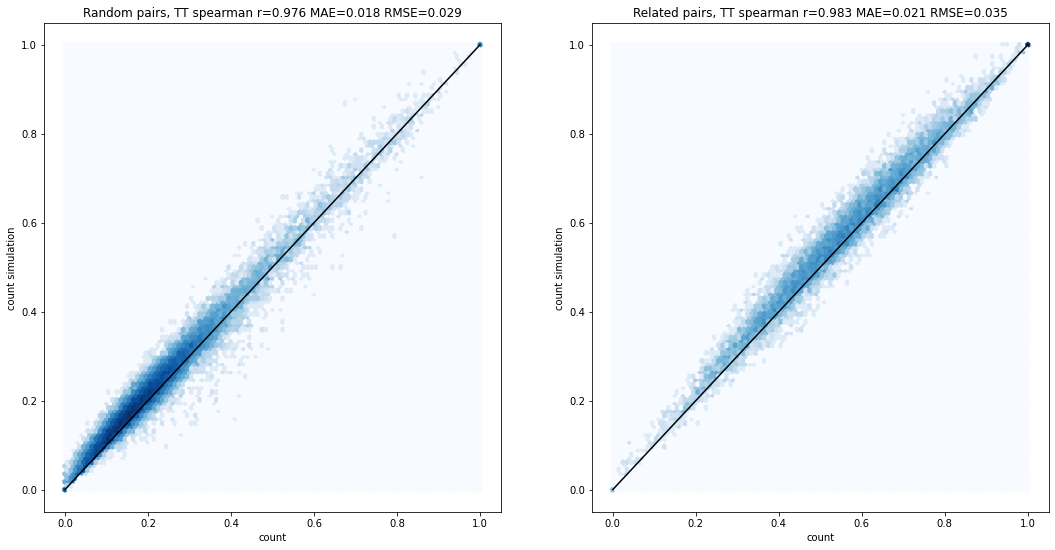

In [24]:
figsize(18,9)
subplot(1,2,1)
x,y = countsims,fpsims_countsim
hexbin(x,y,cmap='Blues',bins='log');
plot((0,1),(0,1),'k');
ylabel('count simulation')
xlabel('count');
sr,p = spearmanr(x,y)
mae = median_absolute_error(x,y)
rmse = sqrt(mean_squared_error(x,y))
title(f'Random pairs, TT spearman r={sr:.3f} MAE={mae:.3f} RMSE={rmse:.3f}');

subplot(1,2,2)
x,y = related_countsims,related_fpsims_countsim
hexbin(x,y,cmap='Blues',bins='log');
plot((0,1),(0,1),'k');
ylabel('count simulation')
xlabel('count');
sr,p = spearmanr(x,y)
mae = median_absolute_error(x,y)
rmse = sqrt(mean_squared_error(x,y))
title(f'Related pairs, TT spearman r={sr:.3f} MAE={mae:.3f} RMSE={rmse:.3f}');



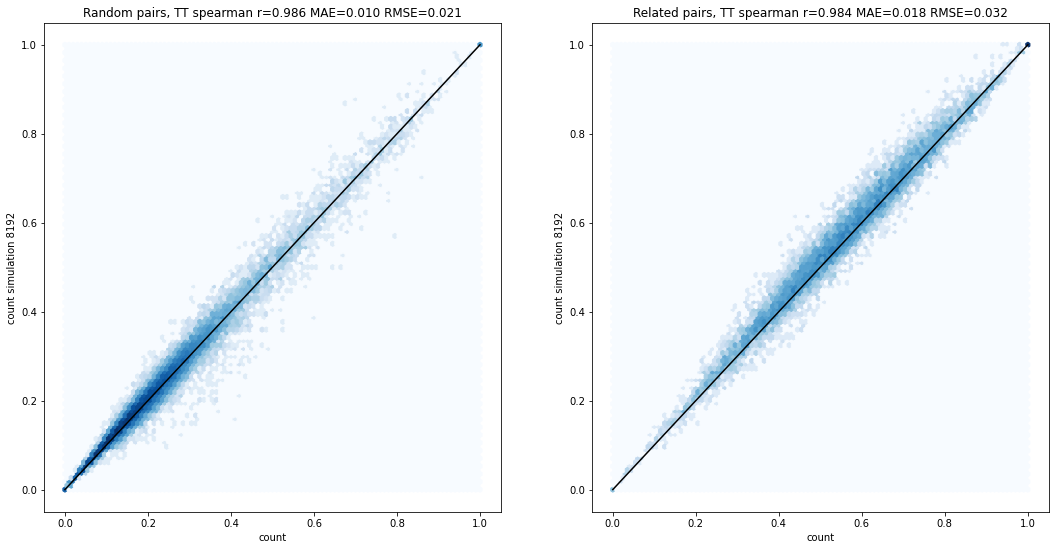

In [25]:
fpgen3 = rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=8192,countSimulation=True)
fpsims_countsim2 = [DataStructs.TanimotoSimilarity(fpgen3.GetFingerprint(x[0]),fpgen3.GetFingerprint(x[1])) for x in ms]
related_fpsims_countsim2 = [DataStructs.TanimotoSimilarity(fpgen3.GetFingerprint(x[0]),fpgen3.GetFingerprint(x[1])) for x in related_ms]
figsize(18,9)
subplot(1,2,1)
x,y = countsims,fpsims_countsim2
hexbin(x,y,cmap='Blues',bins='log');
plot((0,1),(0,1),'k');
ylabel('count simulation 8192')
xlabel('count');
sr,p = spearmanr(x,y)
mae = median_absolute_error(x,y)
rmse = sqrt(mean_squared_error(x,y))
title(f'Random pairs, TT spearman r={sr:.3f} MAE={mae:.3f} RMSE={rmse:.3f}');

subplot(1,2,2)
x,y = related_countsims,related_fpsims_countsim2
hexbin(x,y,cmap='Blues',bins='log');
plot((0,1),(0,1),'k');
ylabel('count simulation 8192')
xlabel('count');
sr,p = spearmanr(x,y)
mae = median_absolute_error(x,y)
rmse = sqrt(mean_squared_error(x,y))
title(f'Related pairs, TT spearman r={sr:.3f} MAE={mae:.3f} RMSE={rmse:.3f}');

## Atom pairs

In [26]:
fpgen1 = rdFingerprintGenerator.GetAtomPairGenerator(fpSize=2048,countSimulation=False)
fpsims = [DataStructs.TanimotoSimilarity(fpgen1.GetFingerprint(x[0]),fpgen1.GetFingerprint(x[1])) for x in ms]
countsims = [DataStructs.TanimotoSimilarity(fpgen1.GetCountFingerprint(x[0]),fpgen1.GetCountFingerprint(x[1])) for x in ms]
related_fpsims = [DataStructs.TanimotoSimilarity(fpgen1.GetFingerprint(x[0]),fpgen1.GetFingerprint(x[1])) for x in related_ms]
related_countsims = [DataStructs.TanimotoSimilarity(fpgen1.GetCountFingerprint(x[0]),fpgen1.GetCountFingerprint(x[1])) for x in related_ms]

fpgen2 = rdFingerprintGenerator.GetAtomPairGenerator(fpSize=2048,countSimulation=True)
fpsims_countsim = [DataStructs.TanimotoSimilarity(fpgen2.GetFingerprint(x[0]),fpgen2.GetFingerprint(x[1])) for x in ms]
related_fpsims_countsim = [DataStructs.TanimotoSimilarity(fpgen2.GetFingerprint(x[0]),fpgen2.GetFingerprint(x[1])) for x in related_ms]


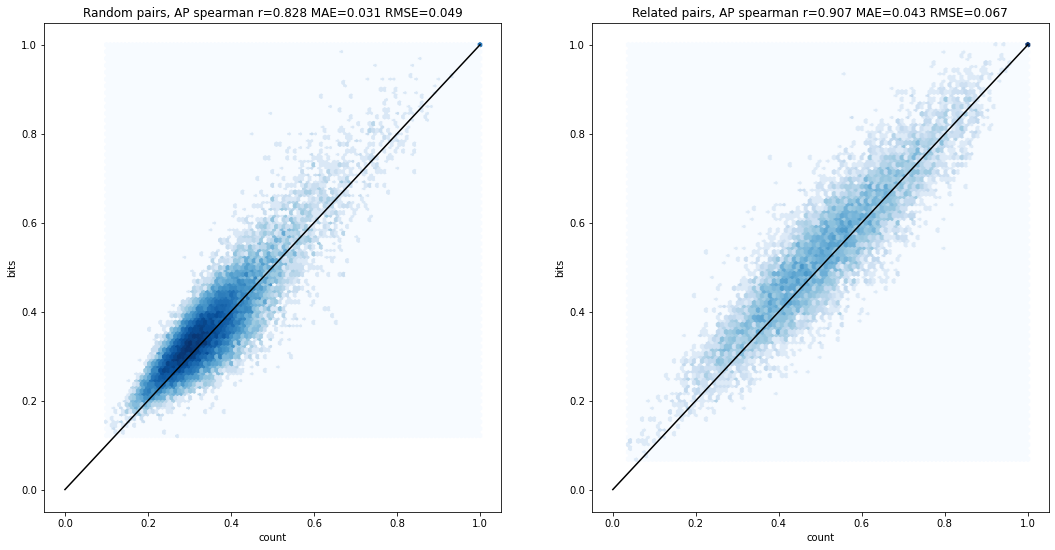

In [27]:
figsize(18,9)
subplot(1,2,1)
y,x = fpsims,countsims
hexbin(x,y,cmap='Blues',bins='log');
plot((0,1),(0,1),'k');
xlabel('count')
ylabel('bits');
sr,p = spearmanr(x,y)
mae = median_absolute_error(x,y)
rmse = sqrt(mean_squared_error(x,y))
title(f'Random pairs, AP spearman r={sr:.3f} MAE={mae:.3f} RMSE={rmse:.3f}');

subplot(1,2,2)
y,x = related_fpsims,related_countsims
hexbin(x,y,cmap='Blues',bins='log');
plot((0,1),(0,1),'k');
xlabel('count')
ylabel('bits');
sr,p = spearmanr(x,y)
mae = median_absolute_error(x,y)
rmse = sqrt(mean_squared_error(x,y))
title(f'Related pairs, AP spearman r={sr:.3f} MAE={mae:.3f} RMSE={rmse:.3f}');



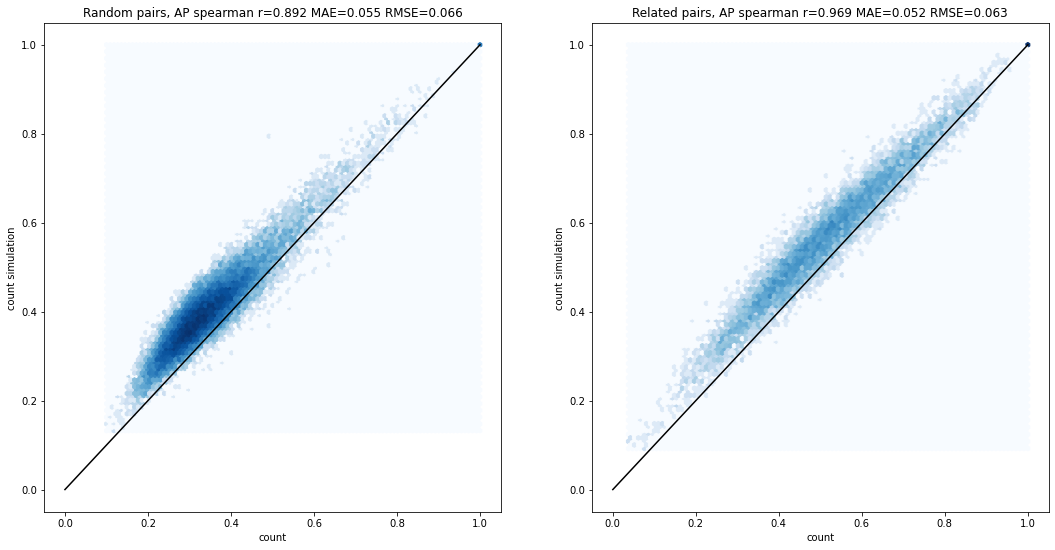

In [28]:
figsize(18,9)
subplot(1,2,1)
x,y = countsims,fpsims_countsim
hexbin(x,y,cmap='Blues',bins='log');
plot((0,1),(0,1),'k');
ylabel('count simulation')
xlabel('count');
sr,p = spearmanr(x,y)
mae = median_absolute_error(x,y)
rmse = sqrt(mean_squared_error(x,y))
title(f'Random pairs, AP spearman r={sr:.3f} MAE={mae:.3f} RMSE={rmse:.3f}');

subplot(1,2,2)
x,y = related_countsims,related_fpsims_countsim
hexbin(x,y,cmap='Blues',bins='log');
plot((0,1),(0,1),'k');
ylabel('count simulation')
xlabel('count');
sr,p = spearmanr(x,y)
mae = median_absolute_error(x,y)
rmse = sqrt(mean_squared_error(x,y))
title(f'Related pairs, AP spearman r={sr:.3f} MAE={mae:.3f} RMSE={rmse:.3f}');



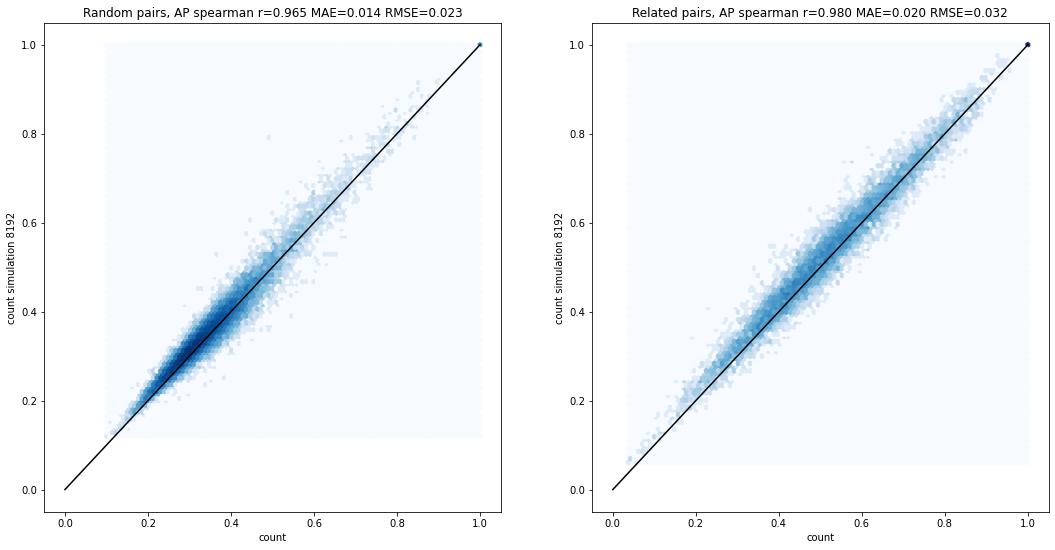

In [29]:
fpgen3 = rdFingerprintGenerator.GetAtomPairGenerator(fpSize=8192,countSimulation=True)
fpsims_countsim2 = [DataStructs.TanimotoSimilarity(fpgen3.GetFingerprint(x[0]),fpgen3.GetFingerprint(x[1])) for x in ms]
related_fpsims_countsim2 = [DataStructs.TanimotoSimilarity(fpgen3.GetFingerprint(x[0]),fpgen3.GetFingerprint(x[1])) for x in related_ms]


figsize(18,9)
subplot(1,2,1)
x,y = countsims,fpsims_countsim2
hexbin(x,y,cmap='Blues',bins='log');
plot((0,1),(0,1),'k');
ylabel('count simulation 8192')
xlabel('count');
sr,p = spearmanr(x,y)
mae = median_absolute_error(x,y)
rmse = sqrt(mean_squared_error(x,y))
title(f'Random pairs, AP spearman r={sr:.3f} MAE={mae:.3f} RMSE={rmse:.3f}');


subplot(1,2,2)
x,y = related_countsims,related_fpsims_countsim2
hexbin(x,y,cmap='Blues',bins='log');
plot((0,1),(0,1),'k');
ylabel('count simulation 8192')
xlabel('count');
sr,p = spearmanr(x,y)
mae = median_absolute_error(x,y)
rmse = sqrt(mean_squared_error(x,y))
title(f'Related pairs, AP spearman r={sr:.3f} MAE={mae:.3f} RMSE={rmse:.3f}');

## RDKit Fingerprint

In [30]:
fpgen1 = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=2048,countSimulation=False)
fpsims = [DataStructs.TanimotoSimilarity(fpgen1.GetFingerprint(x[0]),fpgen1.GetFingerprint(x[1])) for x in ms]
countsims = [DataStructs.TanimotoSimilarity(fpgen1.GetCountFingerprint(x[0]),fpgen1.GetCountFingerprint(x[1])) for x in ms]
related_fpsims = [DataStructs.TanimotoSimilarity(fpgen1.GetFingerprint(x[0]),fpgen1.GetFingerprint(x[1])) for x in related_ms]
related_countsims = [DataStructs.TanimotoSimilarity(fpgen1.GetCountFingerprint(x[0]),fpgen1.GetCountFingerprint(x[1])) for x in related_ms]

fpgen2 = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=2048,countSimulation=True)
fpsims_countsim = [DataStructs.TanimotoSimilarity(fpgen2.GetFingerprint(x[0]),fpgen2.GetFingerprint(x[1])) for x in ms]
related_fpsims_countsim = [DataStructs.TanimotoSimilarity(fpgen2.GetFingerprint(x[0]),fpgen2.GetFingerprint(x[1])) for x in related_ms]


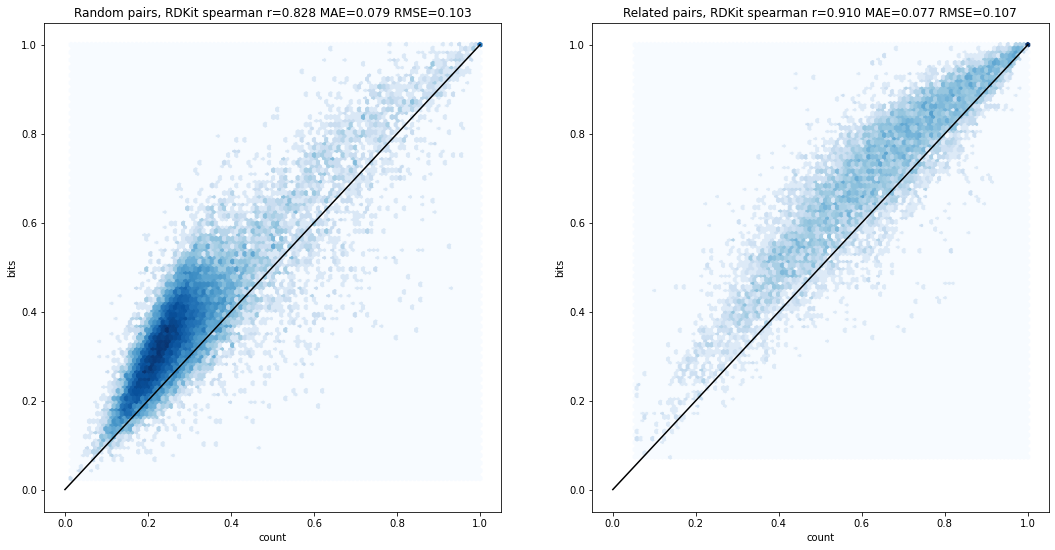

In [31]:
figsize(18,9)

subplot(1,2,1)
y,x = fpsims,countsims
hexbin(x,y,cmap='Blues',bins='log');
plot((0,1),(0,1),'k');
xlabel('count')
ylabel('bits');
sr,p = spearmanr(x,y)
mae = median_absolute_error(x,y)
rmse = sqrt(mean_squared_error(x,y))
title(f'Random pairs, RDKit spearman r={sr:.3f} MAE={mae:.3f} RMSE={rmse:.3f}');

subplot(1,2,2)
y,x = related_fpsims,related_countsims
hexbin(x,y,cmap='Blues',bins='log');
plot((0,1),(0,1),'k');
xlabel('count')
ylabel('bits');
sr,p = spearmanr(x,y)
mae = median_absolute_error(x,y)
rmse = sqrt(mean_squared_error(x,y))
title(f'Related pairs, RDKit spearman r={sr:.3f} MAE={mae:.3f} RMSE={rmse:.3f}');


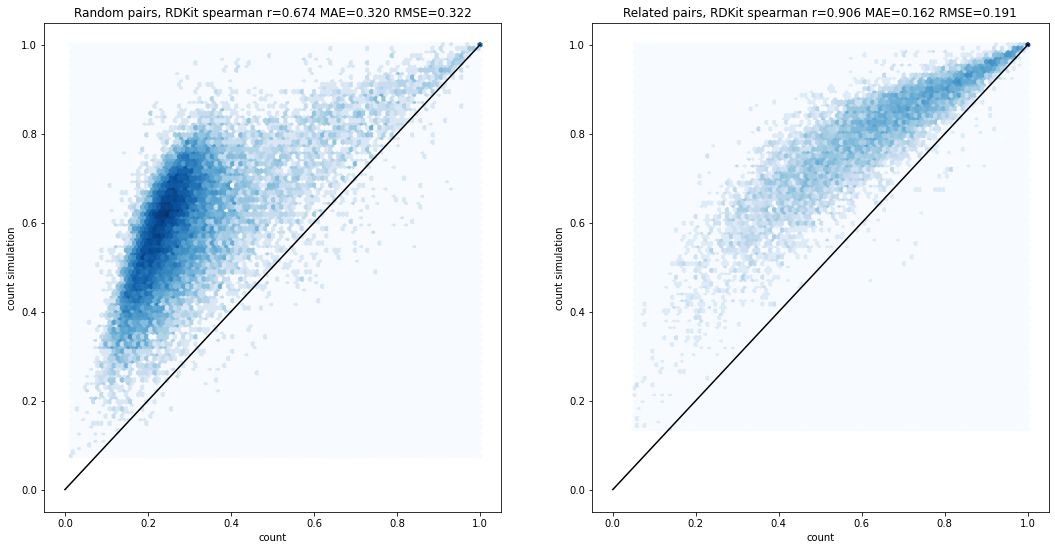

In [32]:
figsize(18,9)

subplot(1,2,1)
x,y = countsims,fpsims_countsim
hexbin(x,y,cmap='Blues',bins='log');
plot((0,1),(0,1),'k');
ylabel('count simulation')
xlabel('count');
sr,p = spearmanr(x,y)
mae = median_absolute_error(x,y)
rmse = sqrt(mean_squared_error(x,y))
title(f'Random pairs, RDKit spearman r={sr:.3f} MAE={mae:.3f} RMSE={rmse:.3f}');

subplot(1,2,2)
x,y = related_countsims,related_fpsims_countsim
hexbin(x,y,cmap='Blues',bins='log');
plot((0,1),(0,1),'k');
ylabel('count simulation')
xlabel('count');
sr,p = spearmanr(x,y)
mae = median_absolute_error(x,y)
rmse = sqrt(mean_squared_error(x,y))
title(f'Related pairs, RDKit spearman r={sr:.3f} MAE={mae:.3f} RMSE={rmse:.3f}');


This is terrible, but I suspect that has to do with the number of bits set by RDKit fingerprints just totally overloading things.

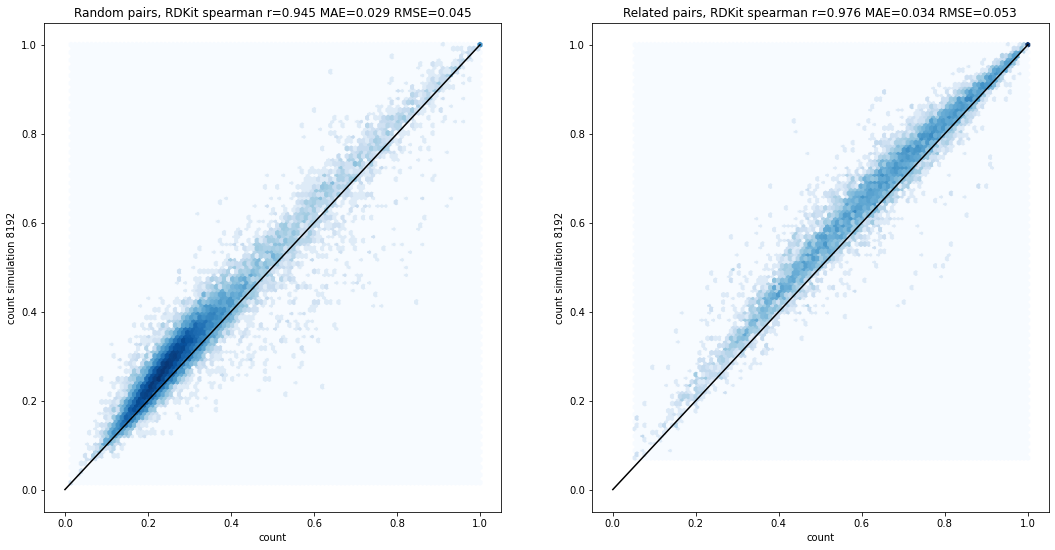

In [33]:
fpgen3 = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=8192,countSimulation=True)
fpsims_countsim2 = [DataStructs.TanimotoSimilarity(fpgen3.GetFingerprint(x[0]),fpgen3.GetFingerprint(x[1])) for x in ms]
related_fpsims_countsim2 = [DataStructs.TanimotoSimilarity(fpgen3.GetFingerprint(x[0]),fpgen3.GetFingerprint(x[1])) for x in related_ms]

figsize(18,9)
subplot(1,2,1)
x,y = countsims,fpsims_countsim2
hexbin(x,y,cmap='Blues',bins='log');
plot((0,1),(0,1),'k');
ylabel('count simulation 8192')
xlabel('count');
sr,p = spearmanr(x,y)
mae = median_absolute_error(x,y)
rmse = sqrt(mean_squared_error(x,y))
title(f'Random pairs, RDKit spearman r={sr:.3f} MAE={mae:.3f} RMSE={rmse:.3f}');

subplot(1,2,2)
x,y = related_countsims,related_fpsims_countsim2
hexbin(x,y,cmap='Blues',bins='log');
plot((0,1),(0,1),'k');
ylabel('count simulation 8192')
xlabel('count');
sr,p = spearmanr(x,y)
mae = median_absolute_error(x,y)
rmse = sqrt(mean_squared_error(x,y))
title(f'Related pairs, RDKit spearman r={sr:.3f} MAE={mae:.3f} RMSE={rmse:.3f}');

That's way better